### Data Exploration

In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt

There are 2 netCDF files containing surface meteorological variables (`oaflux_air_sea_fluxes_train.nc`) and marine heatwave labels (`marine_heatwave_labels_train.nc`). All data is averaged monthly on a 1º global grid from 1981-09-01 through 2015-12-01.

**Load & visualize the data:**

In [2]:
def plot_maps(var, **kwargs):
    '''Creates global maps of data variables using Cartopy'''
    fig = plt.figure(figsize=(8,4)) 
    ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=200))
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) 
    ax.coastlines(resolution='110m', color='black', linewidth=1)
    cont = var.plot.contourf(vmin=var.quantile(.2), vmax=var.quantile(.95), transform=ccrs.PlateCarree(), extend='both', add_labels=True, add_colorbar=False)
    cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
    if 'units' in kwargs:
        cbar.set_label(kwargs['units'], fontsize=12)
    if 'title' in kwargs:
        plt.title(kwargs['title'], fontsize=12) 
    return plt.show()

In [3]:
def plot_time_series(var):
    '''Plot global mean time series of data variables'''
    fig = plt.figure(figsize=(8,4)) 
    var.plot()
    return plt.show()

In [4]:
!ls data/*.nc

data/ERA5.nc			      data/mhw_labels.nc
data/OAFlux.nc			      data/oaflux_air_sea_fluxes_train.nc
data/era5_air_sea_fluxes_test.nc      data/preprocessed_OISST.nc
data/marine_heatwave_labels_train.nc


In [5]:
# Marine Heatwave Labels
mhw = xr.open_dataset('data/marine_heatwave_labels_train.nc', engine='netcdf4')
mhw

<xarray.Dataset>
Dimensions:    (lon: 360, lat: 180, time: 412)
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time       (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2015-12-01
Data variables:
    lsmask     (lat, lon) float32 ...
    mhw_label  (time, lat, lon) float32 ...

In [6]:
# Objectively Analyzed air-sea Fluxes (OAFlux) for the Global Oceans
oaflux = xr.open_dataset('data/oaflux_air_sea_fluxes_train.nc', engine='netcdf4')
oaflux

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 180, time: 412)
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2015-12-01
Data variables:
    evapr    (time, lat, lon) float32 ...
    lhtfl    (time, lat, lon) float32 ...
    nlwrs    (time, lat, lon) float32 ...
    hum2m    (time, lat, lon) float32 ...
    qnet     (time, lat, lon) float32 ...
    shtfl    (time, lat, lon) float32 ...
    nswrs    (time, lat, lon) float32 ...
    tmp2m    (time, lat, lon) float32 ...
    tmpsf    (time, lat, lon) float32 ...
    wnd10    (time, lat, lon) float32 ...

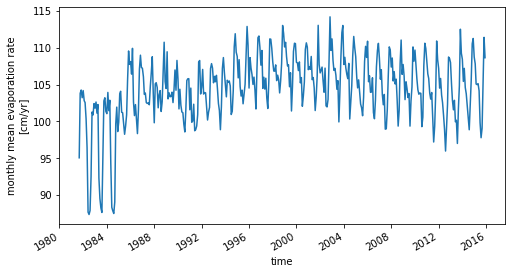

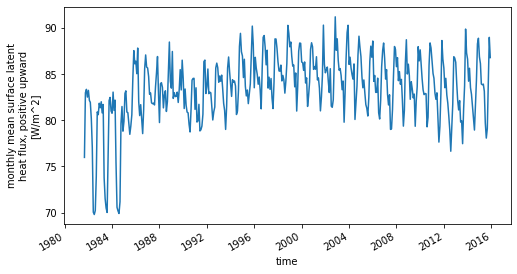

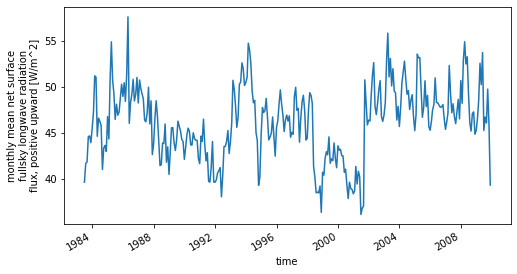

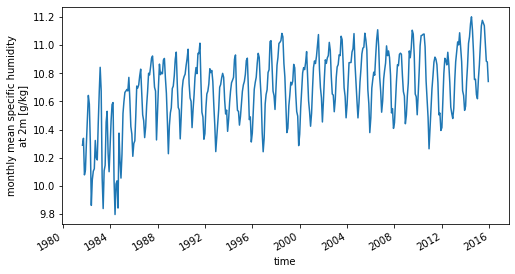

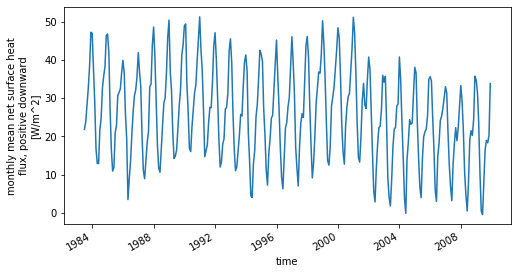

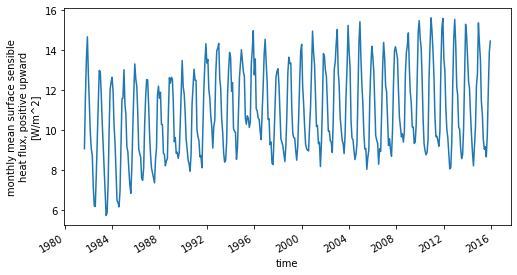

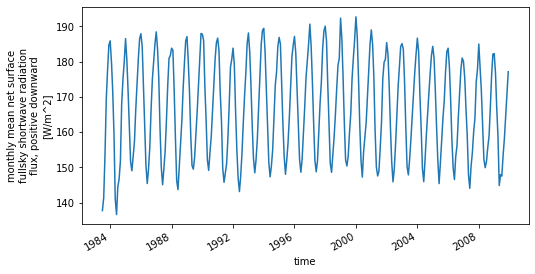

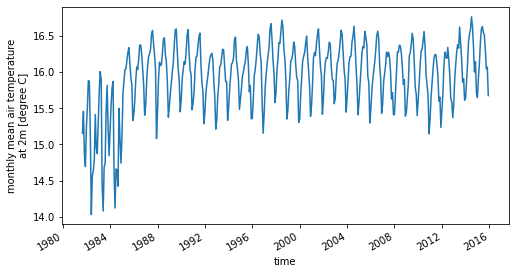

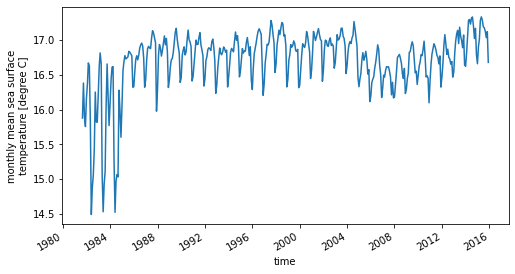

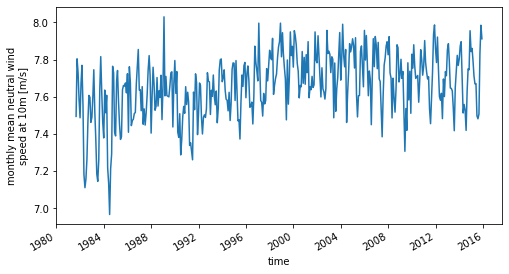

In [7]:
# Plot global mean time series

oaflux_space_mean = oaflux.mean(('lat','lon'), keep_attrs=True)

figs = [plot_time_series(oaflux_space_mean[i]) for i in list(oaflux_space_mean.keys())]

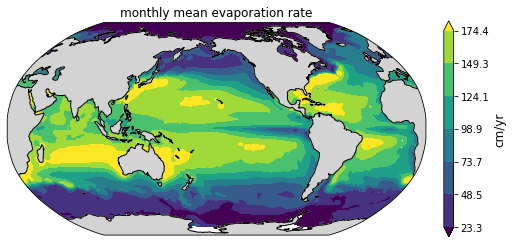

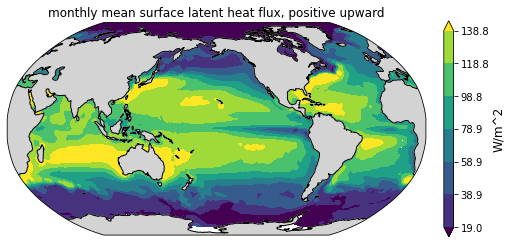

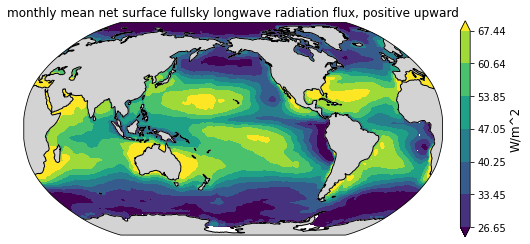

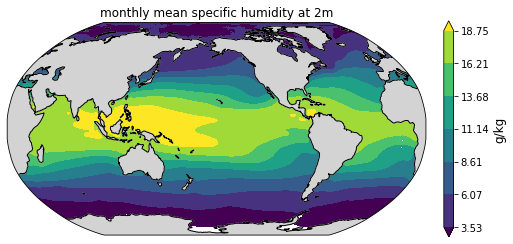

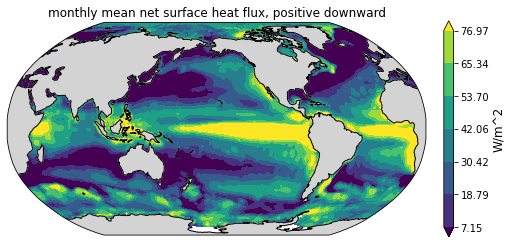

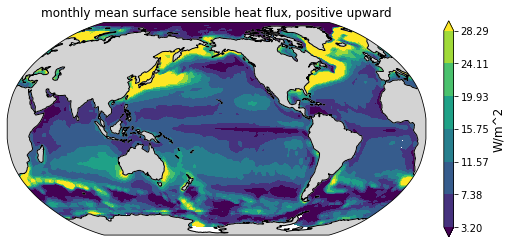

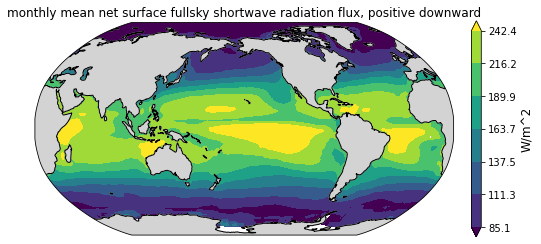

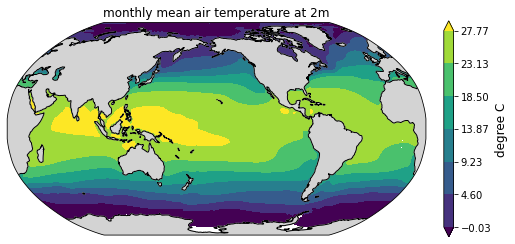

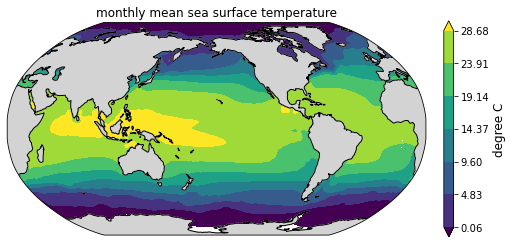

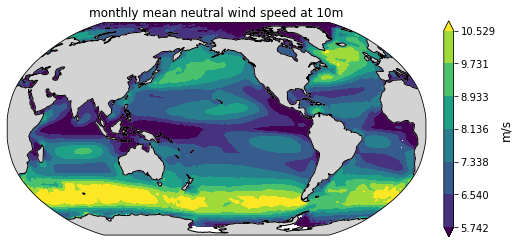

In [8]:
# Plot spatial maps averaged across entire dataset 

oaflux_mean = oaflux.mean('time', keep_attrs=True)
        
figs = [plot_maps(oaflux_mean[i], units=oaflux_mean[i].attrs['units'], title=oaflux_mean[i].attrs['long_name']) for i in list(oaflux_mean.keys())]

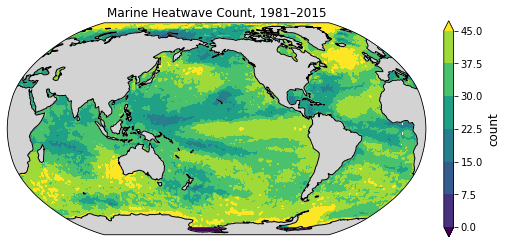

In [9]:
plot_maps(mhw.mhw_label.sum('time', keep_attrs=True), units='count', 
          title=f'Marine Heatwave Count, {mhw.time[0].dt.year.values}–{mhw.time[-1].dt.year.values}')        


## Are data variables aligned?

Some of the variables in OAFlux have empty time slices at the begining and end of the record. 

We need to find where all variables overlap in time.

In [10]:
var_sum = oaflux.sum(('lat','lon'))
start_dates = [var_sum[i].where(var_sum[i]>0, drop=True).time[0].values for i in list(oaflux.keys())] # make a list of all the start dates for each variable
end_dates = [var_sum[i].where(var_sum[i]>0, drop=True).time[-1].values for i in list(oaflux.keys())] # make a list of all the end dates for each variable
print(f'Overlapping period extends between {np.array(start_dates).max()} – {np.array(end_dates).min()}')


Overlapping period extends between 1983-07-01T00:00:00.000000000 – 2009-12-01T00:00:00.000000000
